In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [2]:
file_path = '/kaggle/input/foodpricenepal/wfp_food_prices_npl.csv' 
df = pd.read_csv(file_path)

/tmp/ipykernel_35/405075184.py:2: DtypeWarning: Columns (4,5,6,9,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [3]:
df = df.drop(index=0).reset_index(drop=True)
df.columns = [
    "date", "province", "district", "market", "market_id",
    "latitude", "longitude", "category", "commodity", "commodity_id",
    "unit", "price_flag", "price_type", "currency", "price", "usd_price"]


In [4]:
df.head()

,date,province,district,market,market_id,latitude,longitude,category,commodity,commodity_id,unit,price_flag,price_type,currency,price,usd_price
0,2001-04-15,Province No. 1,DHANKUTA,Dhankuta,647,26.98,87.33,cereals and tubers,Rice (coarse),60,KG,actual,Retail,NPR,17.1,0.24
1,2001-04-15,Province No. 1,DHANKUTA,Dhankuta,647,26.98,87.33,cereals and tubers,Wheat flour,58,KG,actual,Retail,NPR,19,0.27
2,2001-04-15,Province No. 1,ILAM,Ilam,649,26.91,87.94,cereals and tubers,Rice (coarse),60,KG,actual,Retail,NPR,13.5,0.19
3,2001-04-15,Province No. 1,ILAM,Ilam,649,26.91,87.94,cereals and tubers,Wheat flour,58,KG,actual,Retail,NPR,16,0.22
4,2001-04-15,Province No. 1,JHAPA,Jhapa,661,26.48,87.85,cereals and tubers,Rice (coarse),60,KG,actual,Retail,NPR,13.37,0.19


In [5]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38409 entries, 0 to 38408
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          38409 non-null  object
 1   province      38409 non-null  object
 2   district      38409 non-null  object
 3   market        38409 non-null  object
 4   market_id     38409 non-null  object
 5   latitude      38409 non-null  object
 6   longitude     38409 non-null  object
 7   category      38409 non-null  object
 8   commodity     38409 non-null  object
 9   commodity_id  38409 non-null  object
 10  unit          38409 non-null  object
 11  price_flag    38409 non-null  object
 12  price_type    38409 non-null  object
 13  currency      38409 non-null  object
 14  price         38409 non-null  object
 15  usd_price     38409 non-null  object
dtypes: object(16)
memory usage: 4.7+ MB


date            0
province        0
district        0
market          0
market_id       0
latitude        0
longitude       0
category        0
commodity       0
commodity_id    0
unit            0
price_flag      0
price_type      0
currency        0
price           0
usd_price       0
dtype: int64

In [6]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['date'].isna().sum()

0

In [7]:
df.head()

,date,province,district,market,market_id,latitude,longitude,category,commodity,commodity_id,unit,price_flag,price_type,currency,price,usd_price
0,2001-04-15,Province No. 1,DHANKUTA,Dhankuta,647,26.98,87.33,cereals and tubers,Rice (coarse),60,KG,actual,Retail,NPR,17.1,0.24
1,2001-04-15,Province No. 1,DHANKUTA,Dhankuta,647,26.98,87.33,cereals and tubers,Wheat flour,58,KG,actual,Retail,NPR,19,0.27
2,2001-04-15,Province No. 1,ILAM,Ilam,649,26.91,87.94,cereals and tubers,Rice (coarse),60,KG,actual,Retail,NPR,13.5,0.19
3,2001-04-15,Province No. 1,ILAM,Ilam,649,26.91,87.94,cereals and tubers,Wheat flour,58,KG,actual,Retail,NPR,16,0.22
4,2001-04-15,Province No. 1,JHAPA,Jhapa,661,26.48,87.85,cereals and tubers,Rice (coarse),60,KG,actual,Retail,NPR,13.37,0.19


In [8]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
print("Date conversion issues (NaT count):", df['date'].isna().sum())


Date conversion issues (NaT count): 0


In [9]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df = df.dropna(subset=['price'])

excluded_categories = ['non-food', 'meat, fish and eggs', 'milk and dairy']
df = df[~df['category'].isin(excluded_categories)]

excluded_commodities = ['Fuel (diesel)', 'Fuel (petrol-gasoline)', 'Eggs', 'Fish', 'Meat (chicken)', 'Milk']
df = df[~df['commodity'].isin(excluded_commodities)]

df = df.reset_index(drop=True)


In [10]:
print("Categories after filter:", df['category'].unique())
print("Commodities after filter:", df['commodity'].unique())


Categories after filter: ['cereals and tubers' 'oil and fats' 'pulses and nuts'
 'vegetables and fruits']
Commodities after filter: ['Rice (coarse)' 'Wheat flour' 'Potatoes (red)' 'Rice (medium grain)'
 'Oil (mustard)' 'Oil (soybean)' 'Beans (black)' 'Chickpeas'
 'Lentils (broken)' 'Peanut' 'Apples' 'Bananas' 'Cabbage' 'Carrots'
 'Tomatoes' 'Pumpkin' 'Oranges']


In [11]:
# Ensure 'price' column is numeric
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Optional: check if any values became NaN (non-numeric)
print("NaN values in price:", df['price'].isna().sum())

# Drop rows with NaN price
df = df.dropna(subset=['price'])

NaN values in price: 0


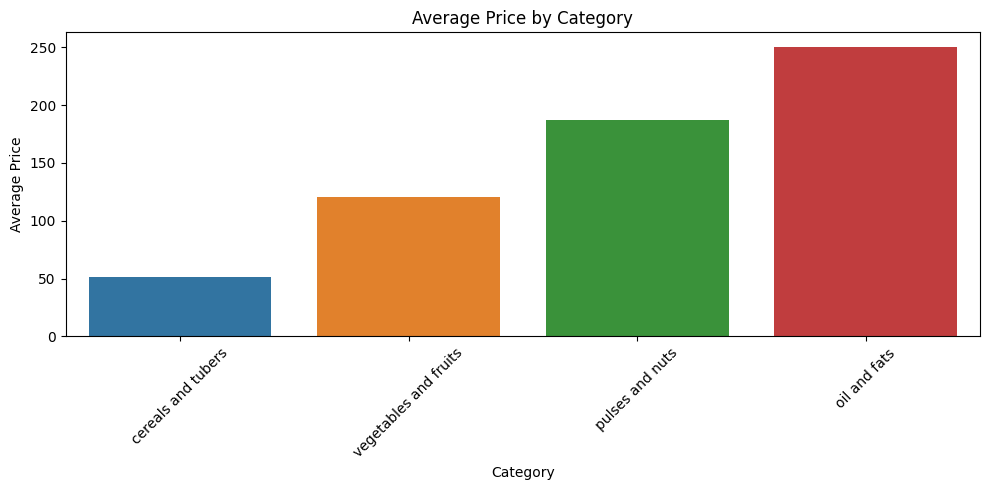

In [12]:
# Average price per category
category_price = df.groupby("category")["price"].mean().sort_values()

plt.figure(figsize=(10,5))
sns.barplot(x=category_price.index, y=category_price.values)
plt.xticks(rotation=45)
plt.title("Average Price by Category")
plt.ylabel("Average Price")
plt.xlabel("Category")
plt.tight_layout()
plt.show()


In [13]:
useful_columns = ['date', 'province', 'category', 'commodity', 'price']
df = df[useful_columns]


In [14]:
df.head()

,date,province,category,commodity,price
0,2001-04-15,Province No. 1,cereals and tubers,Rice (coarse),17.10
1,2001-04-15,Province No. 1,cereals and tubers,Wheat flour,19.00
2,2001-04-15,Province No. 1,cereals and tubers,Rice (coarse),13.50
3,2001-04-15,Province No. 1,cereals and tubers,Wheat flour,16.00
4,2001-04-15,Province No. 1,cereals and tubers,Rice (coarse),13.37


In [15]:
df.to_csv('crop-prediction.csv', index=False)

In [16]:
!pip install prophet

from prophet import Prophet


In [17]:
rice_df = df[df['commodity'] == 'Rice (coarse)'].copy()

# Group by date to get average price
rice_df = rice_df.groupby('date').agg({'price': 'mean'}).reset_index()
rice_df.columns = ['ds', 'y']  # Prophet needs 'ds' and 'y'


In [18]:
model = Prophet()
model.fit(rice_df)


06:38:42 - cmdstanpy - INFO - Chain [1] start processing
06:38:42 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
future = model.make_future_dataframe(periods=30)  # forecast next 30 days
forecast = model.predict(future)


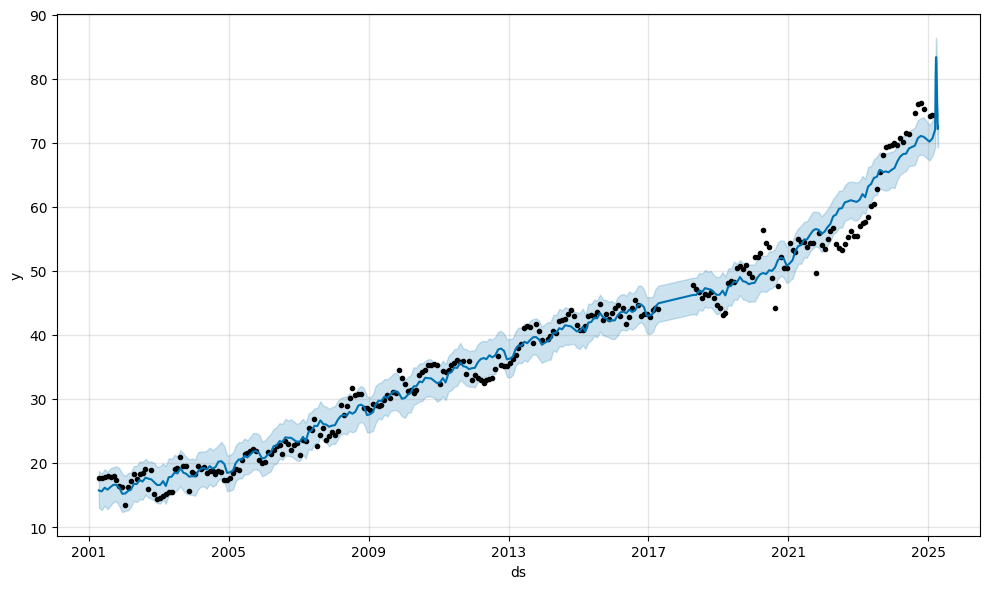

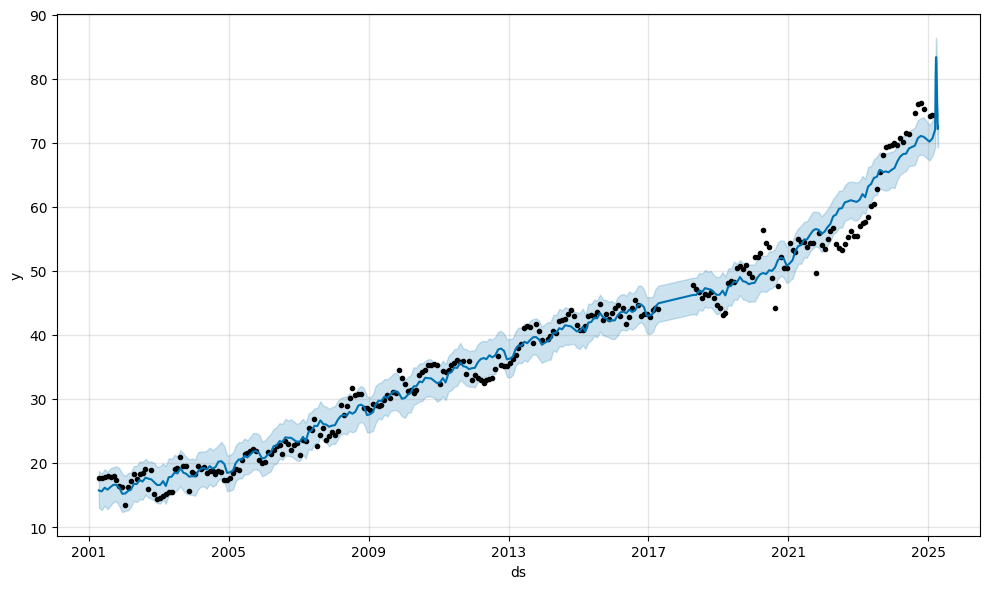

In [20]:
model.plot(forecast)


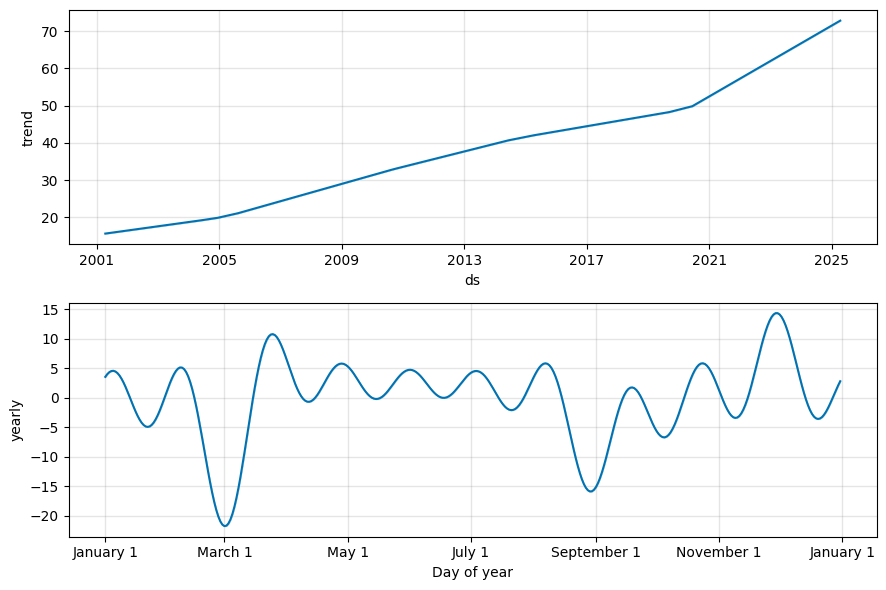

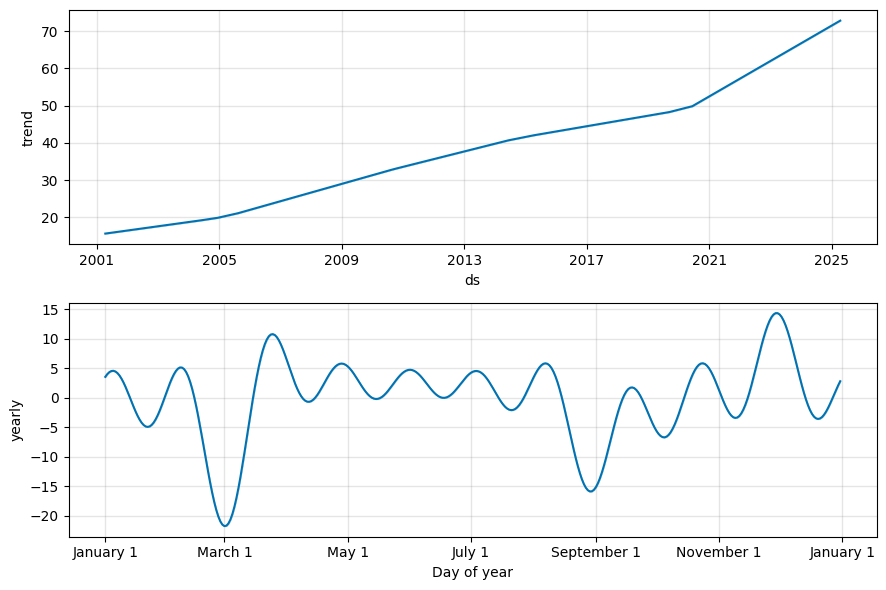

In [21]:
model.plot_components(forecast)


In [22]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
grouped = df.groupby(['commodity', 'province', 'month'])['price'].mean().reset_index()
grouped.rename(columns={'price': 'avg_price'}, inplace=True)

In [23]:
print("Categories after filter:", grouped['province'].unique())
print("Commodities after filter:", grouped['commodity'].unique())


Categories after filter: ['Province No. 1' 'Province No. 2' 'Province No. 3' 'Province No. 4'
 'Province No. 5' 'Province No. 6' 'Province No. 7']
Commodities after filter: ['Apples' 'Bananas' 'Beans (black)' 'Cabbage' 'Carrots' 'Chickpeas'
 'Lentils (broken)' 'Oil (mustard)' 'Oil (soybean)' 'Oranges' 'Peanut'
 'Potatoes (red)' 'Pumpkin' 'Rice (coarse)' 'Rice (medium grain)'
 'Tomatoes' 'Wheat flour']


In [24]:
le_crop = LabelEncoder()
le_province = LabelEncoder()

grouped['crop_encoded'] = le_crop.fit_transform(grouped['commodity'])
grouped['province_encoded'] = le_province.fit_transform(grouped['province'])


In [25]:
grouped.head()


,commodity,province,month,avg_price,crop_encoded,province_encoded
0,Apples,Province No. 1,1,303.055556,0,0
1,Apples,Province No. 1,2,293.500000,0,0
2,Apples,Province No. 1,3,303.611111,0,0
3,Apples,Province No. 1,4,287.000000,0,0
4,Apples,Province No. 1,5,290.588235,0,0


In [26]:
X = grouped[['crop_encoded', 'province_encoded', 'month']]
y = grouped['avg_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📌 Step 6: Train model
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [27]:

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R² Score: {r2:.2f}")


✅ RMSE: 11.26
✅ R² Score: 0.98


In [28]:
def predict_top_months(crop_name, province_name):
    crop_encoded = le_crop.transform([crop_name])[0]
    province_encoded = le_province.transform([province_name])[0]

    test_data = pd.DataFrame({
        'crop_encoded': [crop_encoded]*12,
        'province_encoded': [province_encoded]*12,
        'month': list(range(1, 13))
    })

    predicted_prices = model.predict(test_data)
    top_months_idx = np.argsort(predicted_prices)[-2:][::-1]
    top_months = [(int(test_data.iloc[i]['month']), round(predicted_prices[i], 2)) for i in top_months_idx]

    print(f"\nTop 2 profitable months to sell '{crop_name}' in '{province_name}':")
    for month, price in top_months:
        print(f"  ➤ Month: {month:02d}  |  Predicted Price: Rs. {price:.2f}")

    return top_months


In [29]:
predict_top_months('Bananas','Province No. 2')


Top 2 profitable months to sell 'Bananas' in 'Province No. 2':
  ➤ Month: 06  |  Predicted Price: Rs. 103.49
  ➤ Month: 05  |  Predicted Price: Rs. 91.43


[(6, 103.49), (5, 91.43)]

In [ ]:
import joblib

filename = 'crop_price_model.pkl'
result = joblib.dump(model, filename)
print("Model saved to:", result)


In [ ]:
import os

print("Files in /kaggle/working/:", os.listdir('/kaggle/working'))
